- Phân cụm các mẫu dữ liệu trong iris dataset dựa trên các chỉ số.
- Tạm thời lấy 3 chỉ số đầu tiên: sepal length, sepal width và petal length để tiện cho plot 3D.

In [327]:
### IMPORT THƯ VIỆN
import numpy as np
from pandas import read_csv
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist # Hàm tính khoảng cách

In [328]:
### ĐỌC FILE
# Đọc file iris.data.csv tải về từ Kaggle: https://www.kaggle.com/datasets/vikrishnan/iris-dataset
path = "iris.data.csv"
fr = read_csv(path, header = None)

# Đưa dữ liệu về numpy array
data = fr.to_numpy()

In [329]:
### SỐ LIỆU CỦA DATA

# Tổng số mẫu
SAMPLE_NUM = len(data)

# Đầu vào dữ liệu
CHARAC_NUM = 3

# Nhãn của dữ liệu
LABEL_NUM = 3
LABEL_NAMES = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

In [330]:
print(SAMPLE_NUM)

150


In [331]:
### CHỌN RA DATA

# Chọn 3 phần tử đầu tiên mỗi sample làm đầu vào
X = data[:, :CHARAC_NUM].astype(np.float64)

# Chọn phần tử cuối cùng mỗi sample làm nhãn (dưới dạng string)
Y = data[:, -1]

In [332]:
### ONE-HOT ENCODING CHO NHÃN

# Tạo một numpy array với toàn 0
labels = np.zeros((SAMPLE_NUM, CHARAC_NUM))

# Chuyển nhãn của labels thành one-hot encoding
for index, label_name in enumerate(LABEL_NAMES):
    """
    Hàm enumerate(labels_name) để trả về cả nhãn được lưu trữ
    trong list, vừa trả về index của giá trị trong list đó.
    
    Ta dùng enumerate vì mong muốn để one-hot encoding có giá
    trị 1 tại index tương ứng với index của nhãn trong list
    các nhãn.

    Y == label_name để trả về một list những giá trị boolean
    với kích thước bằng Y. Trong đó, chỉ những mẫu dữ liệu
    thỏa mãn điều kiện Y == label_name mới có giá trị True,
    còn lại đều là giá trị False.

    Argument index giúp ta truy cập index của nhãn, và đặt
    giá trị 1 cho index tương ứng (one-hot encoding).
    """
    labels[Y == label_name, index] = 1

In [333]:
### CÁC HÀM LIÊN QUAN

def center_init(X: np.array, K: int) -> np.array:
    """
    Chọn ngẫu nhiên k điểm trong tập dữ liệu X làm tâm điểm
    :param X: tập dữ liệu; với shape (SAMPLE_NUM, CHARAC_NUM)
    :param K: số cụm, bằng với LABEL_NUM
    """
    # Tạo list các indices của mẫu dữ liệu
    indices = list(range(150))

    # Chọn K indices từ các indices có sẵn
    K_indices = np.random.choice(indices, K)

    # Trả về các điểm với indices đó
    centers = [X[index] for index in K_indices]
    centers = np.array(centers)

    return centers.astype(np.float64) # Do dtype đang là object

def update_points(X: np.array, centers: np.array, K: int) -> np.array:
    """
    Cập nhật nhãn cho dữ liệu dựa trên tâm gần nhất của nó.

    :param X: tập dữ liệu với shape là (SAMPLE_NUM, CHARAC_NUM)
    :param centers: các tâm điểm với shape là (LABEL_NUM, CHARAC_NUM)
    :param K: số cụm, bằng với LABEL_NUM
    :return: nhãn đã được cập nhật (one-hot encoding)
    """
    # Tạo một array mới với các giá trị toàn là 0
    new_labels = np.zeros(X.shape)

    # Tính khoảng cách của từng điểm đến với các tâm điểm
    distances = cdist(X, centers)

    # Lấy indices của tâm điểm gần nhất của từng điểm
    indices = np.argmin(distances, axis = 1)

    # Cập nhật labels dựa trên indices tâm điểm gần nhất
    for k in range(K):
        new_labels[indices == k, k] = 1

    return new_labels

def update_centers(X: np.array, labels: np.array, K: int) -> np.array:
    """
    Cập nhật tâm điểm của K cụm.
    
    Tâm điểm mới của một cụm là điểm trung bình cộng của các điểm dữ liệu trong cụm đó.
    
    :param X: tập dữ liệu, shape = (SAMPLE_NUM, CHARAC_NUM)
    :param labels: nhãn của dữ liệu, shape = (SAMPLE_NUM, LABEL_NUM)
    :param K: số cụm, bằng với LABEL_NUM
    :return: các tâm mới với shape là (LABEL_NUM, CHARAC_NUM)
    """
    # Khởi tạo center ban đầu
    centers = np.zeros((K, CHARAC_NUM))

    # Cập nhật các center thành điểm trung bình cộng của mỗi cụm
    indices = np.argmax(labels, axis = 1)
    for k in range(K):
        # Lấy ra các điểm dữ liệu thuộc cụm thứ k
        X_k = X[indices == k]
        
        # Tâm điểm của cụm thứ k là điểm trung bình cộng của cụm
        centers[k] = np.mean(X_k, axis = 0)
    
    return centers

def has_converged(centers, new_centers):
    """
    Kiểm tra xem thuật toán đã hội tụ chưa.

    :return: bool
    """
    return (set([tuple(a) for a in centers]) == 
            set([tuple(a) for a in new_centers]))

K = LABEL_NUM

centers = center_init(X, K)

new_labels = update_points(X, centers, K)

new_centers = update_centers(X, new_labels, K)

In [334]:
### HÀM K-MEANS
def kmeans(X, K):
    # Khởi tạo các biến
    centers_list = [center_init(X, K)]
    labels_list = []
    it = 0 
    count = 0

    # Vòng lặp chính
    while True:
        # Dự đoán các nhãn cho từng điểm dựa trên tâm điểm gần nhất
        labels_list.append(update_points(X, centers_list[-1], K))

        # Những tâm điểm mới sẽ là trung bình của những điểm thuộc cụm
        new_centers = update_centers(X, labels_list[-1], K)

        # Dừng chương trình nếu tâm điểm không thay đổi (đã hội tụ)
        if has_converged(centers_list[-1], new_centers):
            break

        # Nếu chưa hội tụ thì tiếp tục thuật toán
        centers_list.append(new_centers)
        it += 1
        count += 1
    
    return (centers_list, labels_list, it) # Return một tuple với 3 giá trị

In [335]:
### MAIN

# Chọn K, ở đây K bằng với số nhãn (3 loài hoa)
K = LABEL_NUM

# Chạy K-means
(out_centers, out_labels, it) = kmeans(X, K)


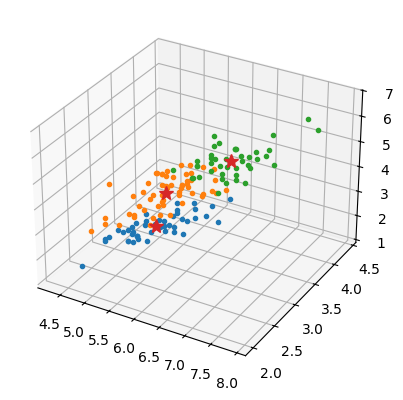

In [336]:
### PLOT KẾT QUẢ
def divide_into_groups(X: np.array, labels: np.array) -> tuple:
    """
    Hàm chia X thành các nhóm dựa trên label.
    :param X: dữ liệu
    :param labels: nhãn dữ liệu
    :return: tuple chứa các nhóm
    """

    # Lấy K
    K = len(labels[0])

    # Tạo một list để chứa các nhóm
    groups = []

    # Chia thành các nhóm dựa trên labels
    indices = np.argmax(labels, axis = 1)
    for k in range(K):
        # Lấy ra các điểm dữ liệu thuộc cụm thứ k
        X_k = X[indices == k]
        groups.append(X_k)

    return tuple(groups)

def plotting_3D(groups: tuple[np.array], centers: np.array = None):
    """
    Plot điểm dữ liệu lên mặt phẳng 3D.
    :param groups: tuple chứa các nhóm điểm.
    :rtype: None
    """
    fig = plt.figure()
    ax = plt.axes(projection='3d')

    for group in groups:
        x_coor = [group[:, dimension] for dimension in range(CHARAC_NUM)]
        ax.plot(*x_coor, ".")
    
    if centers is not None:
        x_coor = [centers[:, dimension] for dimension in range(CHARAC_NUM)]
        ax.plot(*x_coor, "*", markersize = 10, alpha = 1)

groups = divide_into_groups(X, out_labels[-1])
plotting_3D(groups, out_centers[-1])

In [337]:
### TÍNH ĐỘ CHÍNH XÁC CỦA K-MEANS: CHƯA SPLIT TRAIN - TEST
"""
Tập dữ liệu có 3 nhóm chia đều thành 150 mẫu. Mỗi 50 mẫu liên tiếp là một
nhóm.

Do đặc điểm dữ liệu nên ta có thể thực hiện việc chia ra 3 phần bằng nhau
(bằng 50 mẫu), sau đó lấy nhóm lớn nhất và đặt nó là nhóm được chọn.
"""

def check_number_of_classes(labels: np.array) -> list[tuple]:
    classes = []
    for k in range(LABEL_NUM):
        classes.append({0: 0,
                        1: 0,
                        2: 0})
        for point in range(k*50, k*50 + 50):
            label = np.argmax(labels[point])
            classes[k][label] += 1
    return classes

# Với dữ liệu đúng
true_classes = check_number_of_classes(labels)
true_classes == [{0: 50, 1: 0, 2: 0}, {0: 0, 1: 50, 2: 0}, {0: 0, 1: 0, 2: 50}] # True

# Với dữ liệu từ K-means
classes_hat = check_number_of_classes(out_labels[-1])

# Tính toán độ chính xác
correct = 0
for label in classes_hat:
    correct += max(label.values())
percent = correct / SAMPLE_NUM

# Print kết quả
print("Thuật toán K-means phân chia trên tập train với độ chính xác:", percent)

Thuật toán K-means phân chia trên tập train với độ chính xác: 0.88
